In [1]:
# Increase the resolution of your plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Autoreload is handy if the functions within the imports change between runs. 
# Helpful for development!
%load_ext autoreload
%autoreload 2

#Packages we will use
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os
# Nice to have imports
import numpy as np
import pickle
from scipy.stats import norm

# Imports for PTA modeling
import enterprise
from enterprise_extensions import models 
from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions import blocks

# La_forge for loading in chains!
from la_forge.core import Core

# The actual optimal statistic
from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic

libstempo not installed. PINT or libstempo are required to use par and tim files.


# Part 1: Finding a Sine Wave in White Noise

# Simulate Data

In [31]:
# function to create sine wave
def gen_signal(t=None, A=None, f=1e-8, phi=0):
    """
    Return a sinusoid with amplitude A and frequency f and phase phi, 
    sampled at times t.

    :param t: Time samples
    :param A: Amplitude of sine wave
    :param f: Frequency of sine wave
    :param phi: phase of sine wave

    :returns: sine wave at specified t, A, phi and f
    """
    return A*np.sin(2*np.pi*f*t + phi)

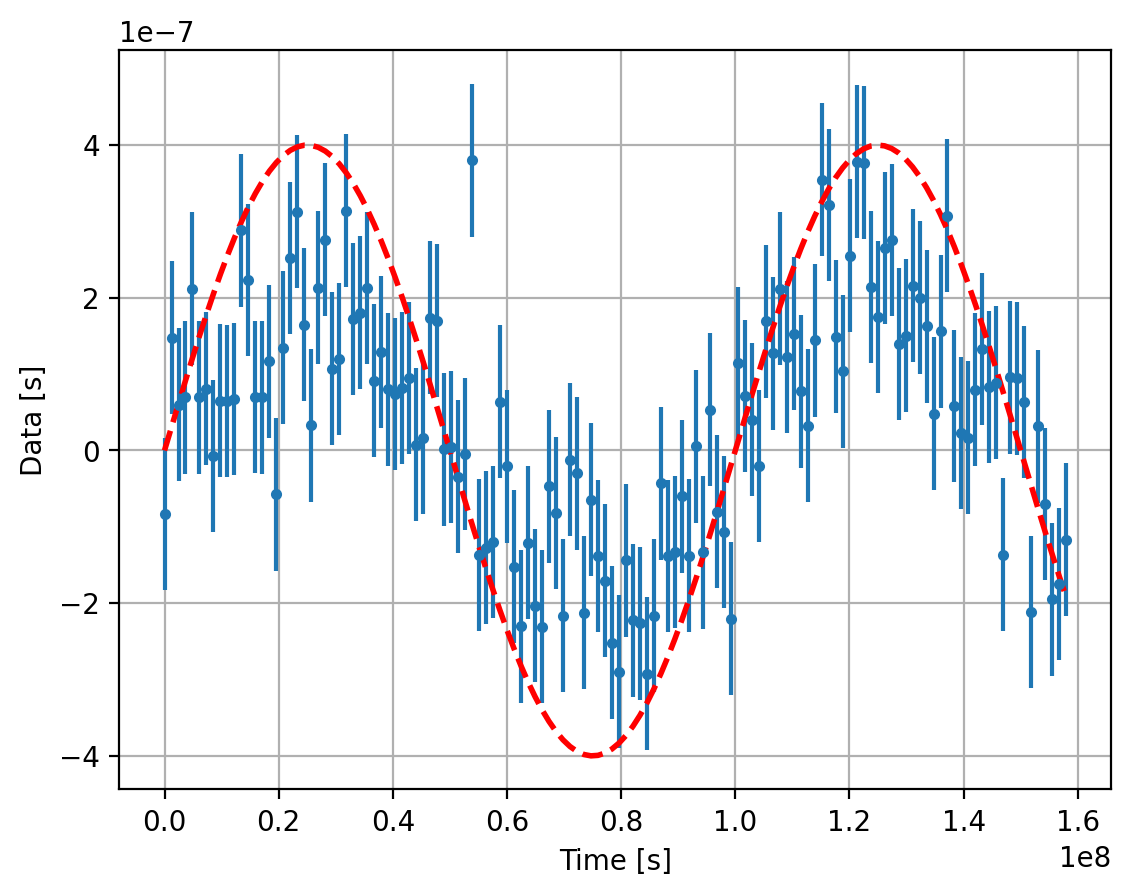

In [182]:
# simulated data
freq = 1e-8
sigma = 1e-7
t = np.linspace(0, 3.16e7*5, 130)
Amp = 2e-7
sig = gen_signal(t=t, A=Amp, f=freq, phi=0)

# call function to simulate data
data = sig + np.random.randn(len(t))*sigma

# plot
plt.errorbar(x=t, y=data, yerr=sigma, fmt='.')
plt.plot(t, signal, lw=2, color='r', ls='--')
plt.xlabel('Time [s]')
plt.ylabel('Data [s]')
plt.grid()

In [183]:
def innerProduct(data, template, sigma):
    """
    Computes the noise weighted inner product
    of the data and template. If data is d and template is s
    each with N samples, then the inner product is

    (d|s) = \sum_{i=0}^N d_i s_i/\sigma^2

    :param data: data time series
    :param template: signal time series
    :param sigma: standard deviation of noise

    :returns: noise weighted inner product
    """
    return np.dot(data, template)/sigma**2

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2419503/1401895429.py:7: SyntaxWarning: invalid escape sequence '\s'


In [184]:
#  maximum likelihood estimator for A
def maxLikeA(data, t, f, sigma):
    sig = gen_signal(t=t, A=1, f=f)
    return innerProduct(data, sig, sigma)/innerProduct(sig, sig, sigma), np.sqrt(1/innerProduct(sig, sig, sigma))

In [185]:
Ahat, stdAhat = maxLikeA(data, t, freq, sigma)
print('MLE for A = {0} +/- {1}'.format(Ahat, stdAhat))
print ('True value of A = {0}'.format(Amp))

MLE for A = 1.9388175298868856e-07 +/- 1.271246487264564e-08
True value of A = 2e-07


In [186]:
Ahat/stdAhat

15.251310814307807

In [187]:
# likelihood function
def LogLikelihood(data, t, A, f, sigma):
    sig = gen_signal(t=t, A=A, f=f)
    return innerProduct(data, sig, sigma) - 0.5 * innerProduct(sig, sig, sigma)

MAP value for A = 1.9369369369369368e-07 +/ 1.2712464872645917e-08
True value of A = 2e-07


Text(0, 0.5, 'p(A|d)')

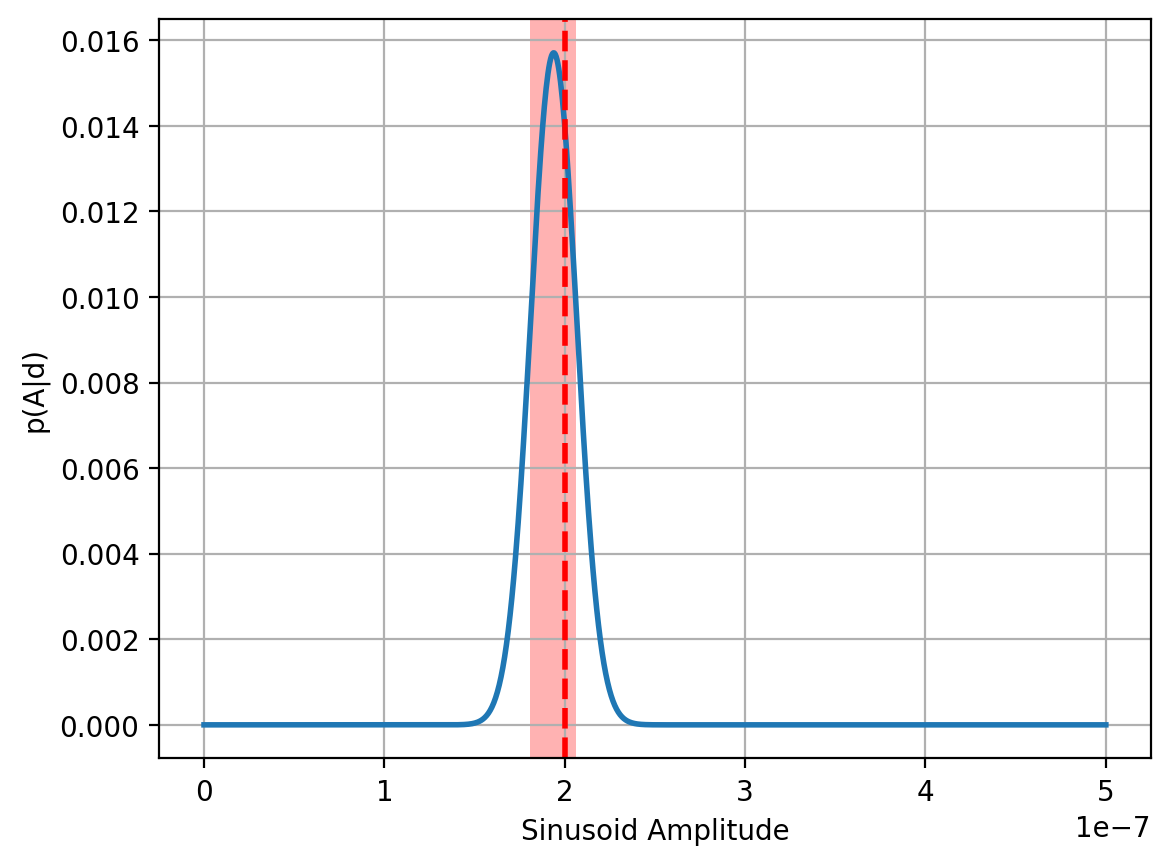

In [188]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

post = np.exp(llike) / (Amps.max()-Amps.min())  
mapA = Amps[np.argmax(post)]
p = post/post.sum()
stdA = np.sqrt(np.sum(Amps**2*p) - np.sum(Amps*p)**2)
print('MAP value for A = {0} +/ {1}'.format(mapA, stdA))
print('True value of A = {0}'.format(Amp))
plt.plot(Amps, p, lw=2)
plt.axvline(Amp, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
#plt.xlim(2e-7, 6e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

MAP value for A = 1.9419419419419418e-07 +/ 1.2511872515350792e-08
True value of A = 2e-07


Text(0, 0.5, 'p(A|d)')

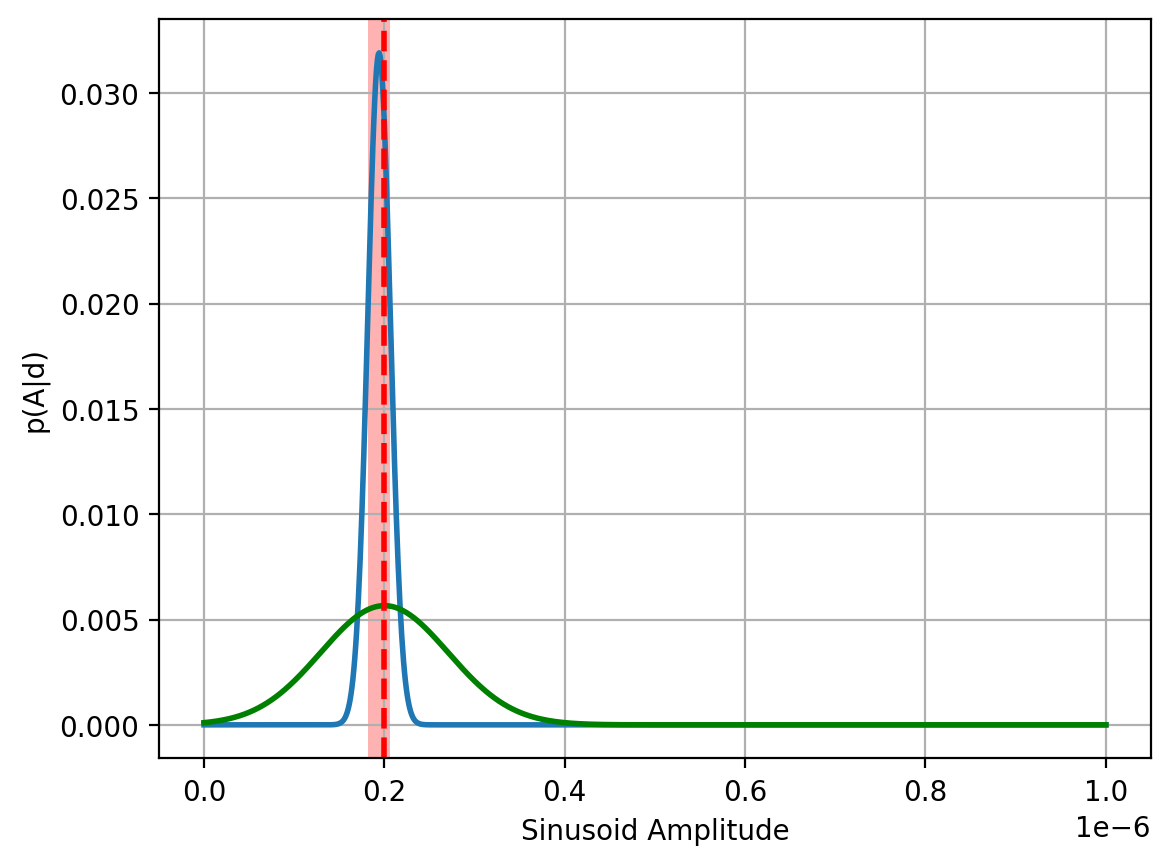

In [206]:
N = 1000
Amps = np.linspace(0, 1e-6, N)
llike2 = np.zeros(N)
logpr2 = np.zeros(N)
sigma_A = Amp * 0.25
for ii in range(N):
    llike2[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma) 
    logpr2[ii] = - 0.5*(np.log(2*np.pi*sigma_A**2) + (Amps[ii]-Amp)**2/2/sigma_A**2)

post2 = np.exp(llike2+logpr2)  
mapA = Amps[np.argmax(post2)]
p2 = post2/post2.sum()
pr = np.exp(logpr2)
pr /= pr.sum()
stdA = np.sqrt(np.sum(Amps**2*p2) - np.sum(Amps*p2)**2)
print ('MAP value for A = {0} +/ {1}'.format(mapA, stdA))
print ('True value of A = {0}'.format(Amp))

plt.plot(Amps, p2, lw=2)
plt.plot(Amps, pr, lw=2, color='g')

plt.axvline(Amp, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
#plt.xlim(0, 1.3e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

In [207]:
mapA/stdA

15.520793866460652

MAP value for A = 1.9669669669669668e-07 +/ 9.454237139584739e-09
True value of A = 2e-07


Text(0, 0.5, 'p(A|d)')

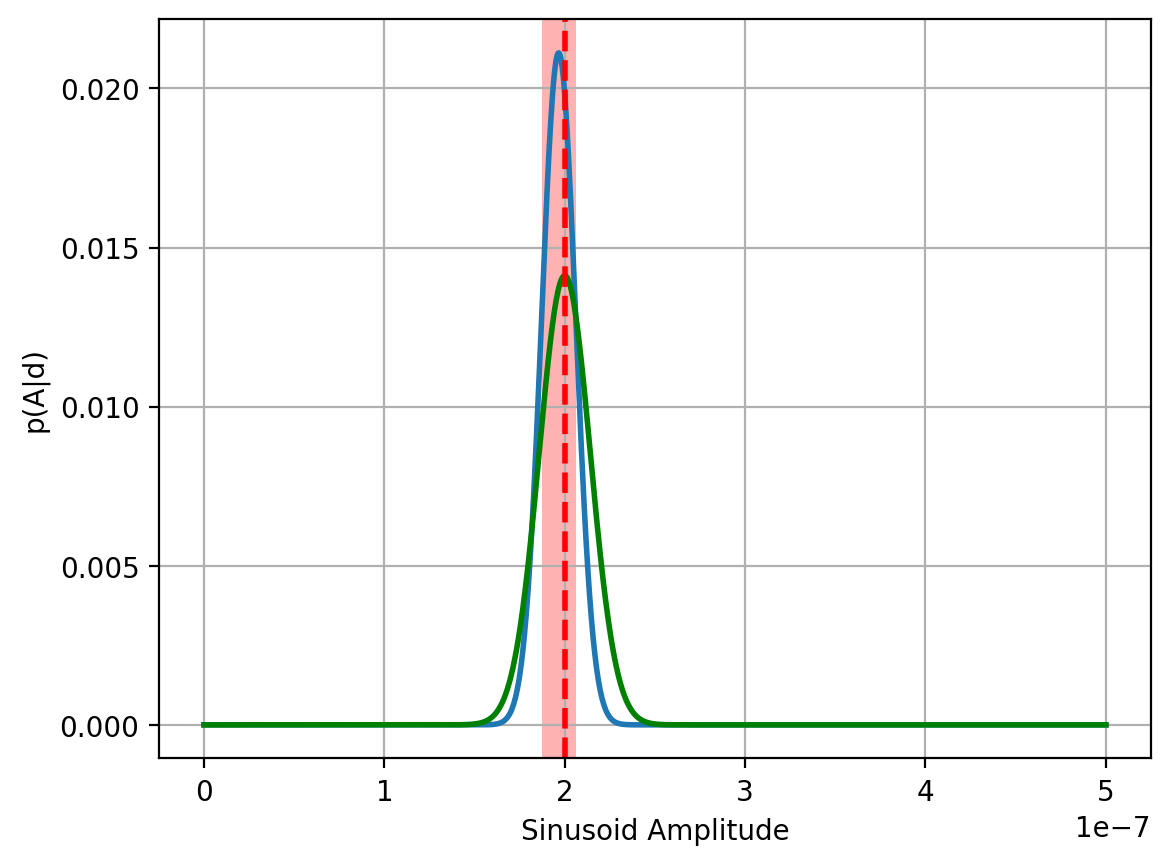

In [208]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
llike2 = np.zeros(N)
logpr2 = np.zeros(N)
sigma_A = Amp * 0.05
for ii in range(N):
    llike2[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma) 
    logpr2[ii] = - 0.5*(np.log(2*np.pi*sigma_A**2) + (Amps[ii]-Amp)**2/2/sigma_A**2)

post2 = np.exp(llike2+logpr2)  
mapA = Amps[np.argmax(post2)]
p2 = post2/post2.sum()
pr = np.exp(logpr2)
pr /= pr.sum()
stdA = np.sqrt(np.sum(Amps**2*p2) - np.sum(Amps*p2)**2)
print ('MAP value for A = {0} +/ {1}'.format(mapA, stdA))
print ('True value of A = {0}'.format(Amp))

plt.plot(Amps, p2, lw=2)
plt.plot(Amps, pr, lw=2, color='g')

plt.axvline(Amp, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
#plt.xlim(0, 1.3e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

# Correlated Signals

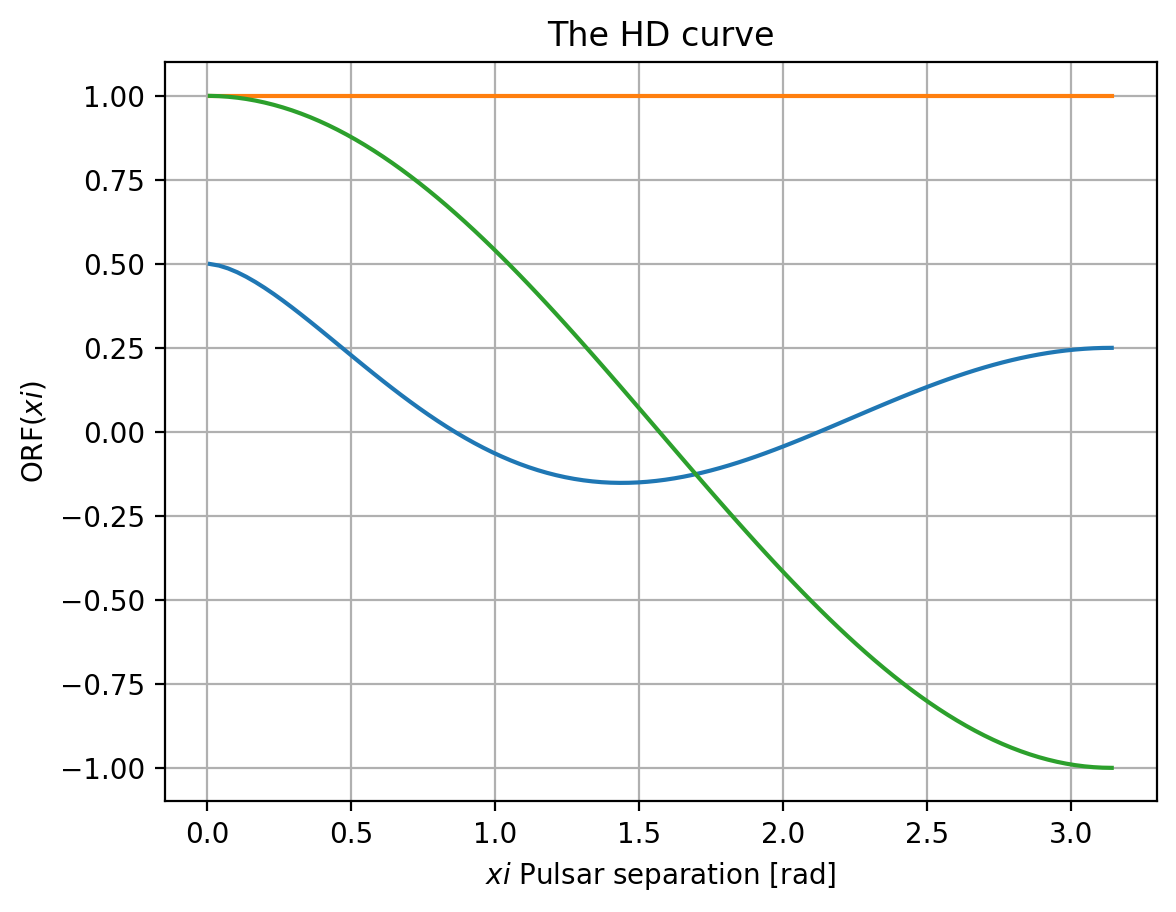

In [209]:

def HD_ORF(xi):
    c = (1-np.cos(xi))/2
    return (1/2) - (c/2)*( (1/2) - 3*np.log(c) )

def Monopole_ORF(xi):
    return np.ones(len(xi))

def Dipole_ORF(xi):
    return np.cos(xi)

# Lets test it!
xi_range = np.linspace(0.01,np.pi,100)
# My function supports vectorization!
HD_curve = HD_ORF(xi_range)
Dipole_curve = Dipole_ORF(xi_range)
Monopole_curve = Monopole_ORF(xi_range)
plt.plot(xi_range,HD_curve, label = 'HD')
plt.plot(xi_range,Monopole_curve, label = 'Monopole')
plt.plot(xi_range,Dipole_curve, label = 'Dipole')
plt.xlabel('$xi$ Pulsar separation [rad]')
plt.ylabel('ORF($xi$)')
plt.title('The HD curve')
plt.grid()
plt.show()

In [210]:
# Lets load up the pulsars
with open('../Data/simulated_ptas/pta1/369.pkl','rb') as f:
    psrs = pickle.load(f)
 

# Since this is a simulated dataset, I happen to know the injected amplitude!
true_amplitude = 2e-15

In [211]:


Tspan = get_tspan(psrs)

efac = models.parameter.Constant(1.0)
equad = models.parameter.Constant(-np.inf) # Basically having no equad
ef = models.white_signals.MeasurementNoise(efac=efac,log10_t2equad=equad)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=5, # Number of GWB frequencies to analyze
                                     gamma_val=None,logmin=-18,logmax=-12,name='gw_crn')

# Importantly, the OS only works with a non-marginalized timing model!
tm = models.gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn 

pta = models.signal_base.PTA([model(psr) for psr in psrs])

In [212]:
chain_dir = "../Chains/enterprise/simulated_ptas/r369/"
pta_core = Core(chain_dir)
wn_dict = {}
for p in psrs:
    wn_dict.update({p.name + "_efac": 1.0})
    wn_dict.update({p.name + "_log10_t2equad": -np.inf})

In [213]:
# Possible ORFs: hd, dipole, monopole

In [214]:
OS_obj = OptimalStatistic(psrs, orf='hd', pta=pta)

In [215]:
# Lets print out all of our parameters
print(pta_core.params)

# That's a lot of parameters... (2*45 intrinsic pulsar parameters + 1 GWB parameter)
# (this will also print some handy things at the end!)

# Next, we need to get the likelihood chain. We can get this through index searching!
like_idx = pta_core.params.index('lnlike')

# Now, grab the full likelihood chain (after removing the burn in)
# chain will have shape (# of mcmc iterations X # of parameters + diagnostic chains)
ln_chain = pta_core.chain[pta_core.burn:, like_idx]

# Now that we have that, we need find the index of the highest likelihood
max_like_idx = np.argmax(ln_chain)

# Now grab the parameter vector (don't forget to burn the chain!)
max_like_vector = pta_core.chain[pta_core.burn + max_like_idx, :]

# But these are just numbers. The OS wants a dictionary, so lets construct that dictionary
max_like_dictionary = {name:value for name,value in zip(pta_core.params, max_like_vector)}

print(max_like_dictionary)

['gw_crn_gamma', 'gw_crn_log10_A', 'lnpost', 'lnlike', 'chain_accept', 'pt_chain_accept']
{'gw_crn_gamma': 4.462956392849078, 'gw_crn_log10_A': -14.761465454334093, 'lnpost': 143172.773466, 'lnlike': 143176.916601, 'chain_accept': 0.427739, 'pt_chain_accept': 1.0}


In [216]:
xi,rho,sig,A_hat_2,A_hat_2s = OS_obj.compute_os(max_like_dictionary)

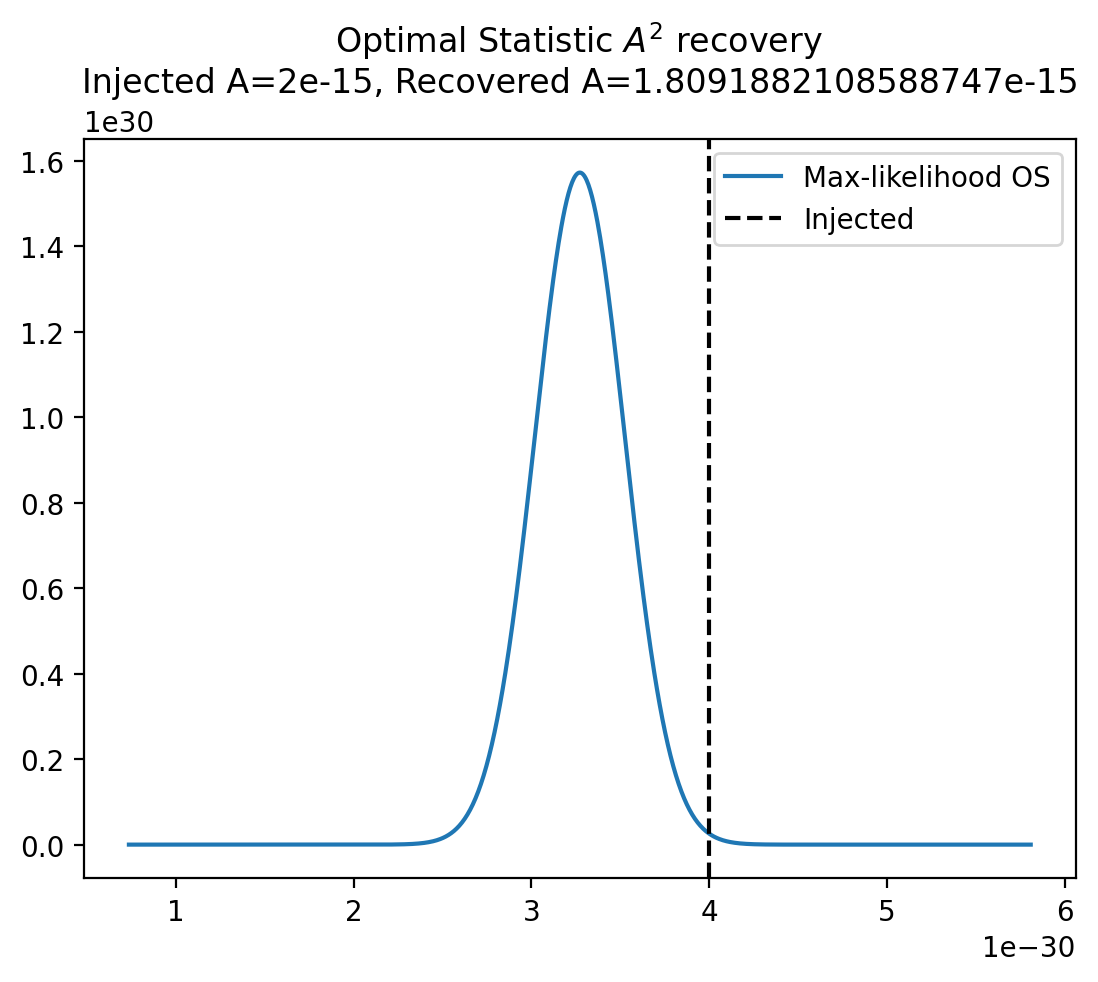

In [217]:
# Now lets plot the fit. Since we use a Gaussian fit, we can express it as such!
max_fit = norm(loc=A_hat_2,scale=A_hat_2s)

# Define a range of amplitude (squared) values to span (lets look at 5-sigma)
A2_range = np.linspace(A_hat_2-10*A_hat_2s,A_hat_2+10*A_hat_2s,1000)

plt.plot(A2_range,max_fit.pdf(A2_range),label=f'Max-likelihood OS')
plt.axvline(true_amplitude**2,linestyle='dashed',color='k',label='Injected')
plt.title(f'Optimal Statistic $A^2$ recovery \nInjected A={true_amplitude}, Recovered A={np.sqrt(A_hat_2)}')
plt.legend()
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\G'
<>:19: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_2419503/1854204761.py:19: SyntaxWarning: invalid escape sequence '\G'


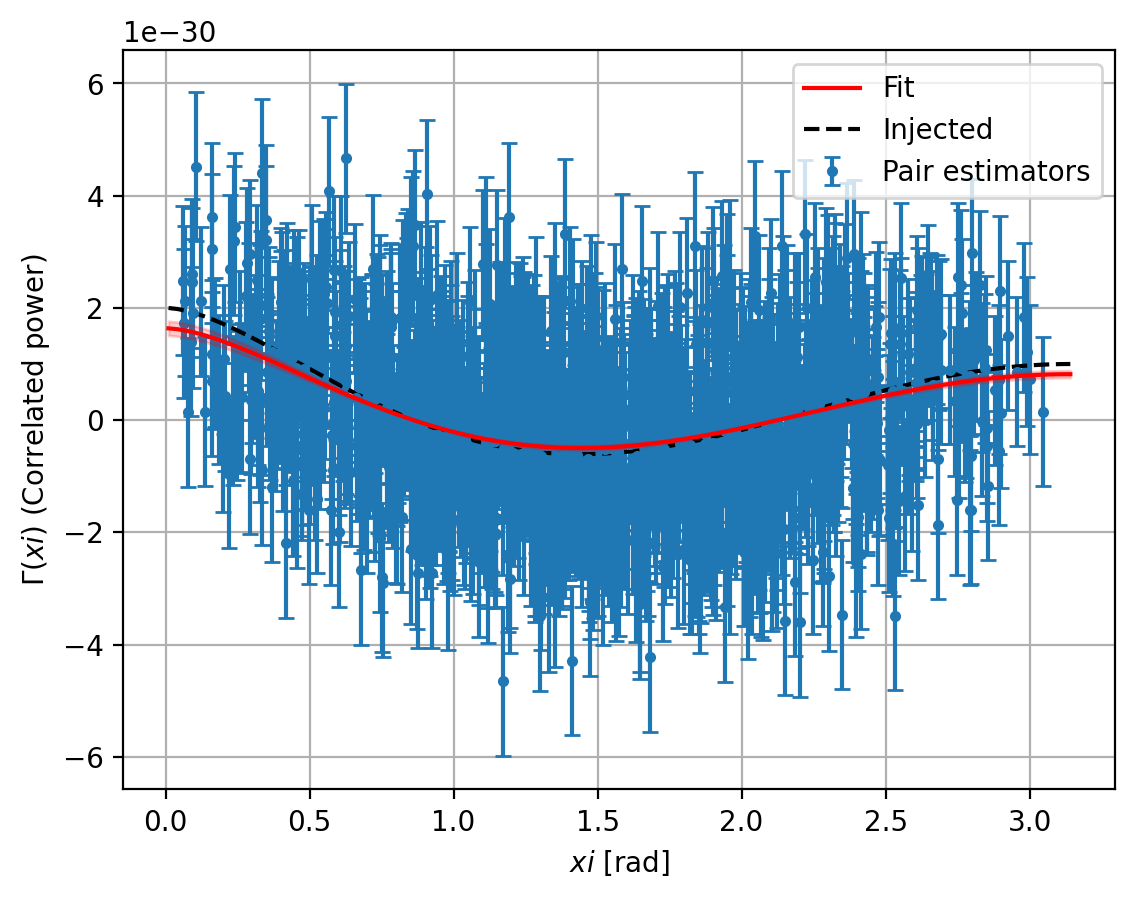

In [218]:
# Plot the pair correlated powers!
plt.errorbar(x=xi, y=rho, yerr=sig, fmt='.', capsize=3,label='Pair estimators')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, A_hat_2*HD_curve,'-r',label='Fit',zorder=100) 

# We can also plot our 1-sigma error bars on A!
plt.fill_between(xi_range, (A_hat_2-A_hat_2s)*HD_curve, 
                 (A_hat_2+A_hat_2s)*HD_curve,
                 color='r',
                 alpha=0.2,
                 zorder=100)


# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

In [219]:
def binned_pair_correlations(xi, rho, sig, bins=10):
    """Create binned separation vs correlations with even pairs per bin.

    This function creates a binned version of the xi, rho, and sig values to better
    vizualize the correlations as a function of pulsar separation. This function uses
    even number of pulsar pairs per bin. Note that this function only works with continuous 
    ORFs in pulsar separation space.

    Args:
        xi (numpy.ndarray): A vector of pulsar pair separations
        rho (numpy.ndarray): A vector of pulsar pair correlated amplitude
        sig (numpy.ndarray): A vector of uncertainties in rho
        bins (int): Number of bins to use. Defaults to 10.

    Returns:
        xiavg (numpy.ndarray): The average pulsar separation in each bin
        rhoavg (numpy.ndarray): The weighted average pulsar pair correlated amplitudes
        sigavg (numpy.ndarray): The uncertainty in the weighted average pair amplitudes
    """
    temp = np.arange(0,len(xi),len(xi)/bins,dtype=np.int16)
    ranges = np.zeros(bins+1)
    ranges[0:bins]=temp
    ranges[bins]=len(xi)
    
    xiavg = np.zeros(bins)
    rhoavg = np.zeros(bins)
    sigavg = np.zeros(bins)
    
    #Need to sort by pulsar separation
    sortMask = np.argsort(xi)
    
    for i in range(bins):
        #Mask and select range of values to average
        subXi = xi[sortMask]
        subXi = subXi[int(ranges[i]):int(ranges[i+1])]
        subRho = rho[sortMask]
        subRho = subRho[int(ranges[i]):int(ranges[i+1])]
        subSig = sig[sortMask]
        subSig = subSig[int(ranges[i]):int(ranges[i+1])]
        
        subSigSquare = np.square(subSig)
        
        xiavg[i] = np.average(subXi)
        rhoavg[i] = np.sum(subRho/subSigSquare)/np.sum(1/subSigSquare)
        sigavg[i] = 1/np.sqrt(np.sum(1/subSigSquare))
    
    return xiavg,rhoavg,sigavg

<>:18: SyntaxWarning: invalid escape sequence '\G'
<>:18: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_2419503/3135782370.py:18: SyntaxWarning: invalid escape sequence '\G'


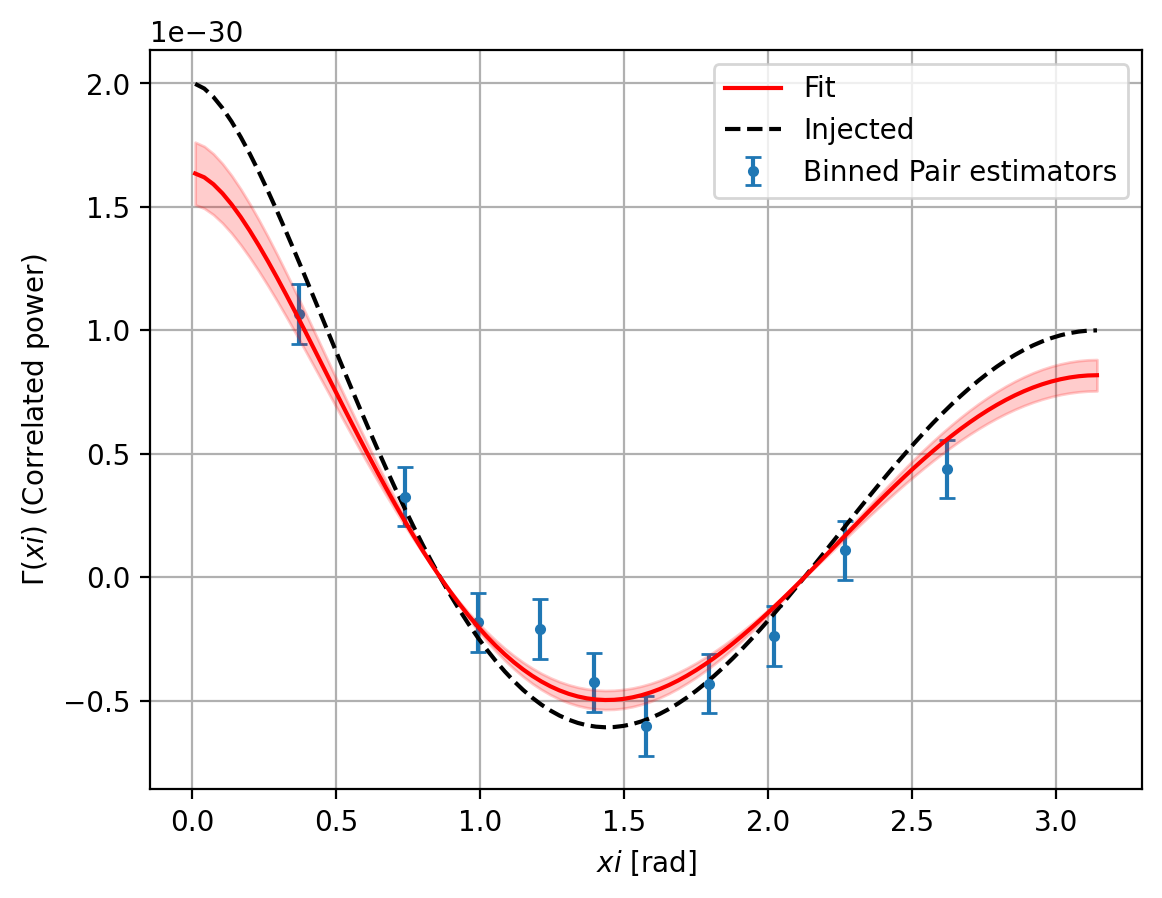

In [220]:
# Get the binned representation
xi_bin, rho_bin, sig_bin = binned_pair_correlations(xi, rho, sig, bins=10)

# Plot the pair correlated powers!
plt.errorbar(x=xi_bin, y=rho_bin, yerr=sig_bin, fmt='.', capsize=3,label='Binned Pair estimators')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, A_hat_2*HD_curve,'-r',label='Fit',zorder=100) 

# We can also plot our 1-sigma error bars on A!
plt.fill_between(xi_range, (A_hat_2-A_hat_2s)*HD_curve, (A_hat_2+A_hat_2s)*HD_curve,color='r',alpha=0.2,zorder=100)


# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

In [221]:
# Lets also print out the SNR
print(f'Max likelihood OS SNR =',A_hat_2/A_hat_2s)

# And also the Z score (i.e. number of sigma the recovery is from the injection)
print(f'Max likelihood OS Z-score =',np.abs(A_hat_2-true_amplitude**2)/A_hat_2s)

Max likelihood OS SNR = 12.903249499206494
Max likelihood OS Z-score = 2.86529427459997


In [222]:
os_chain = pta_core.chain[:-4] # We need to cut off the diagnostic chains (i.e. likelihood, posterior, etc.)
# You can check which parameters are diagnostics by inspecting lfcore.params

os_chain_names = pta_core.params[:-4]

# The number of noise draws N is generally going to be between 1-10 thousand
# the goal is to have a stable distribution! (ask me what it means to be stable)
# this function doesn't have a progress bar, so it may take some time!
xi,nm_rho,nm_sig,nm_A2,nm_SNR = OS_obj.compute_noise_marginalized_os(os_chain,os_chain_names,
                                                                     N=1000)

# This cell took about a minute for me

100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


In [223]:
nm_A2s = nm_A2/nm_SNR

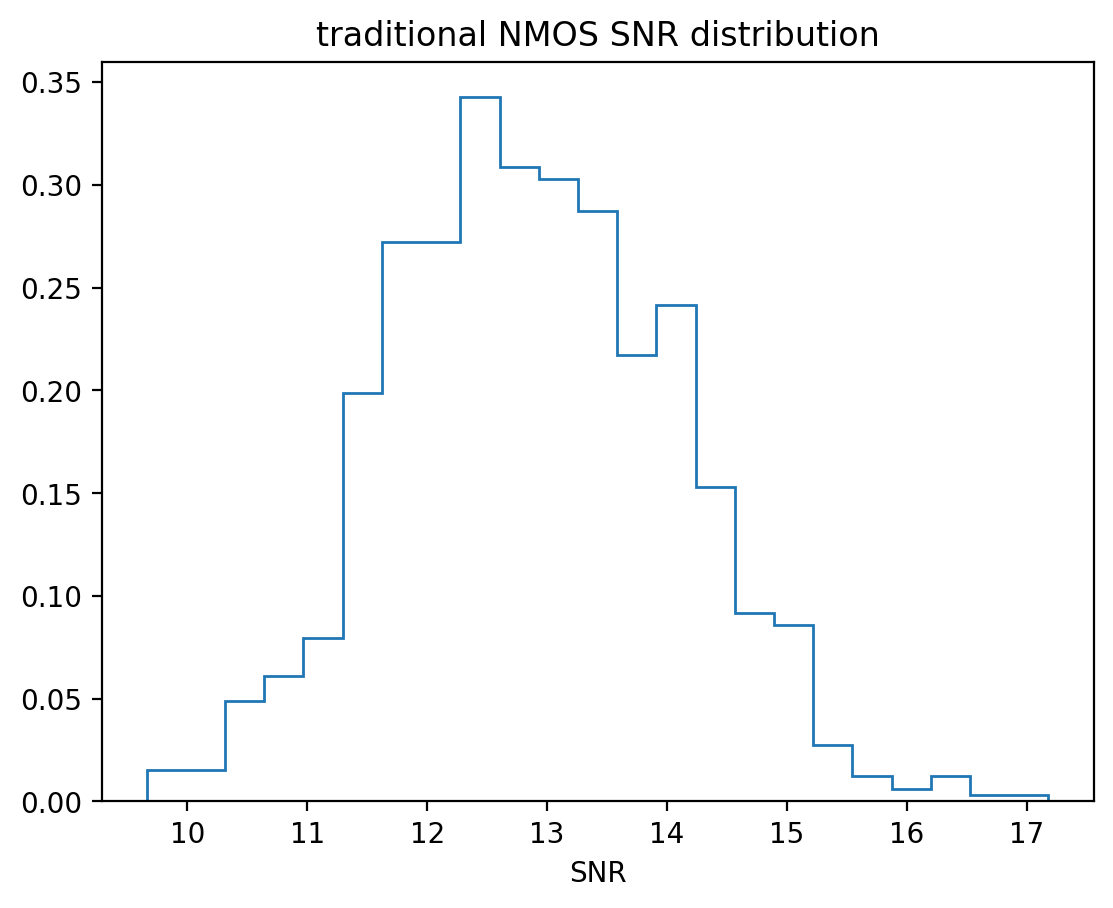

In [224]:
plt.hist(nm_SNR,bins='auto',histtype='step',density=True)
plt.xlabel('SNR')
plt.title('traditional NMOS SNR distribution')
plt.show()